<a href="https://colab.research.google.com/github/Russo-Federico/ML-Projects/blob/main/TimeSeriesForecasting/EnergyConsumptionRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting

Time series prediction applied to kaggle dataset (https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import kagglehub
import os

from google.colab import userdata
from sklearn.metrics import mean_squared_error

In [72]:
# charts config
color_platte = sns.color_palette()
plt.style.use("fivethirtyeight")
sns.set_palette(color_platte)

In [73]:
# retrieving kaggle secrets
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [74]:
# Download dataset
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/hourly-energy-consumption


In [75]:
for root, dirs, files in os.walk(path):
    print("Root:", root)
    print("Dirs:", dirs)
    print("Files:", files[:5])  # print only first 5 files per folder
    print("-"*10)

Root: /kaggle/input/hourly-energy-consumption
Dirs: []
Files: ['est_hourly.paruqet', 'DOM_hourly.csv', 'EKPC_hourly.csv', 'DUQ_hourly.csv', 'DAYTON_hourly.csv']
----------


Read csv into dataframe

In [76]:
df = pd.read_csv(os.path.join(path, "DAYTON_hourly.csv"))
df.head()

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


In [77]:
# set datetime as df index
#df.set_index("Datetime", inplace=True)
df = df.set_index("Datetime")
print('Original index:\n', df.index)

# cast datetime index to correct format
df.index = pd.to_datetime(df.index)
print('\nNew Index:\n', df.index)

Original index:
 Index(['2004-12-31 01:00:00', '2004-12-31 02:00:00', '2004-12-31 03:00:00',
       '2004-12-31 04:00:00', '2004-12-31 05:00:00', '2004-12-31 06:00:00',
       '2004-12-31 07:00:00', '2004-12-31 08:00:00', '2004-12-31 09:00:00',
       '2004-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=121275)

New Index:
 DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
   

In [78]:
if not df.index.is_monotonic_increasing:
  df = df.sort_index()
  print('df sorted by datetime')

df sorted by datetime


<Axes: title={'center': 'DAYTON Hourly Energy Consumption'}, xlabel='Datetime'>

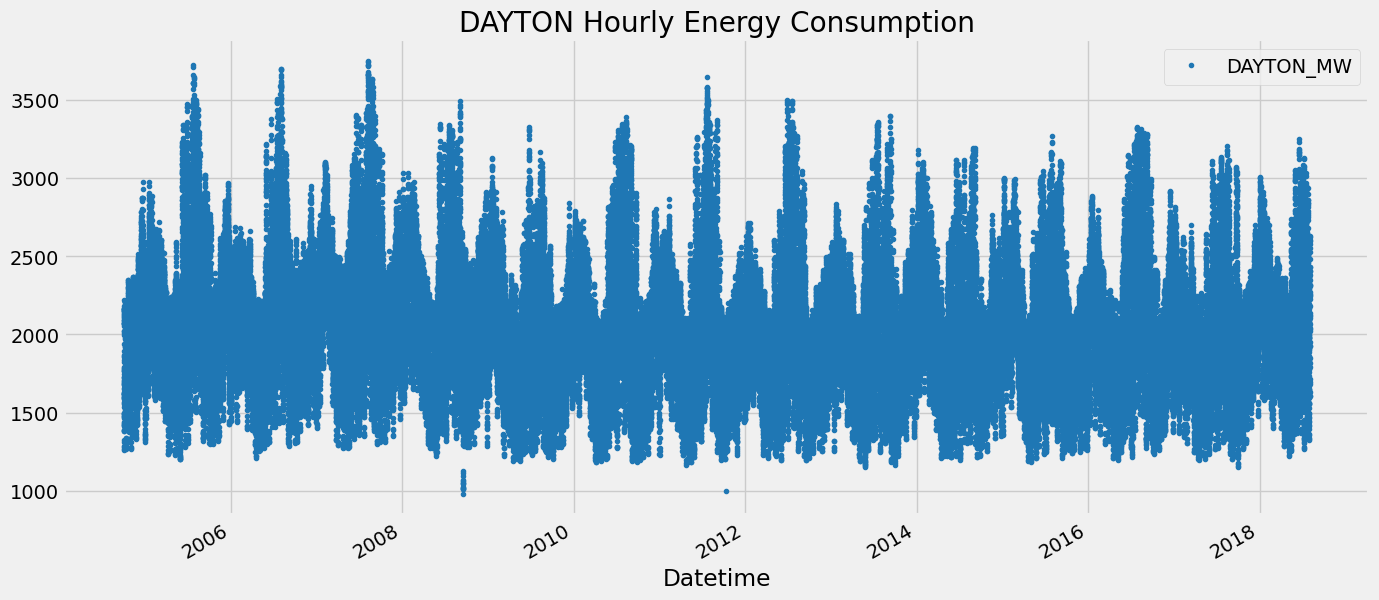

In [79]:
df.plot(style=".", figsize=(15, 7), color=color_platte[0], title="DAYTON Hourly Energy Consumption")

## Split dataset for training and testing

In [80]:
# for time series data we can't use the ordinary train_test_split from sklearn
# we would shuffle the datetimes, more on this at cross validation chapter
train = df.loc[df.index < '2015-01-01'].copy()
test = df.loc[df.index >= '2015-01-01'].copy()

### Charts

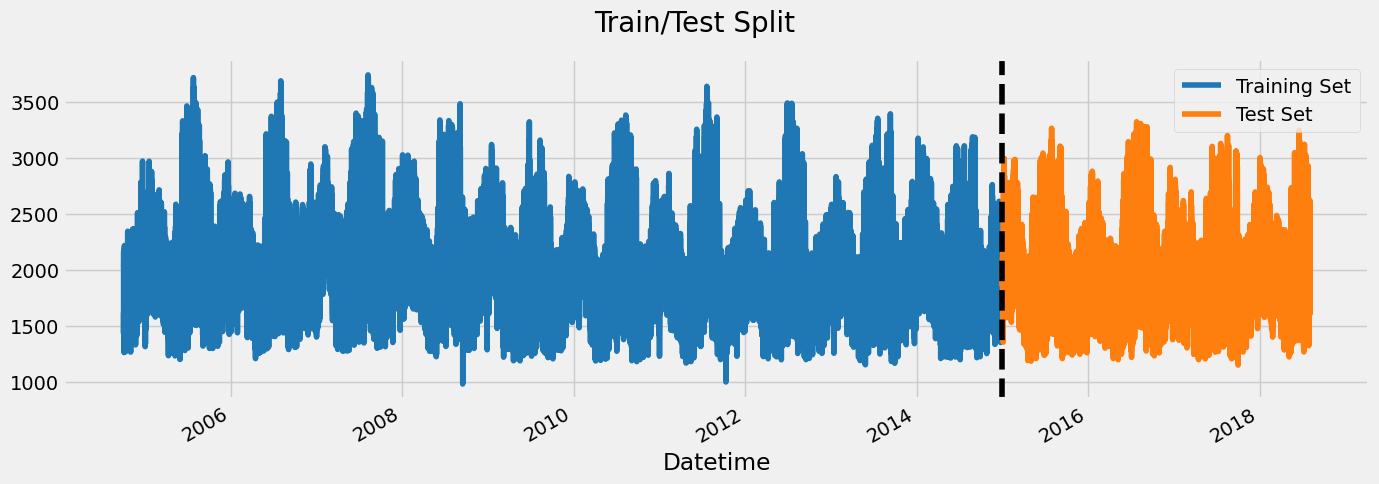

In [81]:
# fig => Figure object, container for n subplots
# ax => Axes object, represents a single subplot
fig, ax = plt.subplots(figsize=(15,5))

train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('2015-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
fig.suptitle("Train/Test Split", fontsize=20)
plt.show()

<Axes: title={'center': 'One Week Plot'}, xlabel='Datetime'>

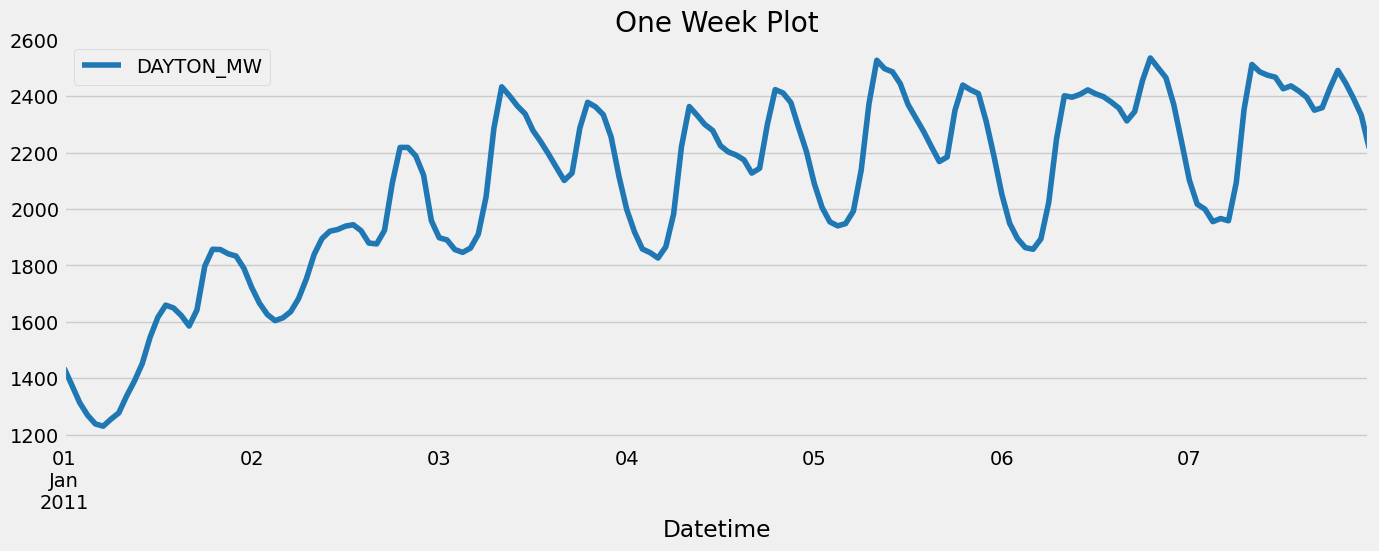

In [82]:
df.loc[(df.index >= '2011-01-01') & (df.index < '2011-01-08')].plot(figsize=(15,5), title='One Week Plot')

## Feature Engineering

In [83]:
def create_features(df):
  """
  create time series features based on time series index
  """
  df = df.copy() # pandas is sure it's working on a copy
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.day_of_week
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.day_of_year

  return df

In [84]:
df = create_features(df)
df.head()

,DAYTON_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2004-10-01 01:00:00,1621.0,1,4,4,10,2004,275
2004-10-01 02:00:00,1536.0,2,4,4,10,2004,275
2004-10-01 03:00:00,1500.0,3,4,4,10,2004,275
2004-10-01 04:00:00,1434.0,4,4,4,10,2004,275
2004-10-01 05:00:00,1489.0,5,4,4,10,2004,275


### Feature Engineering Graphs

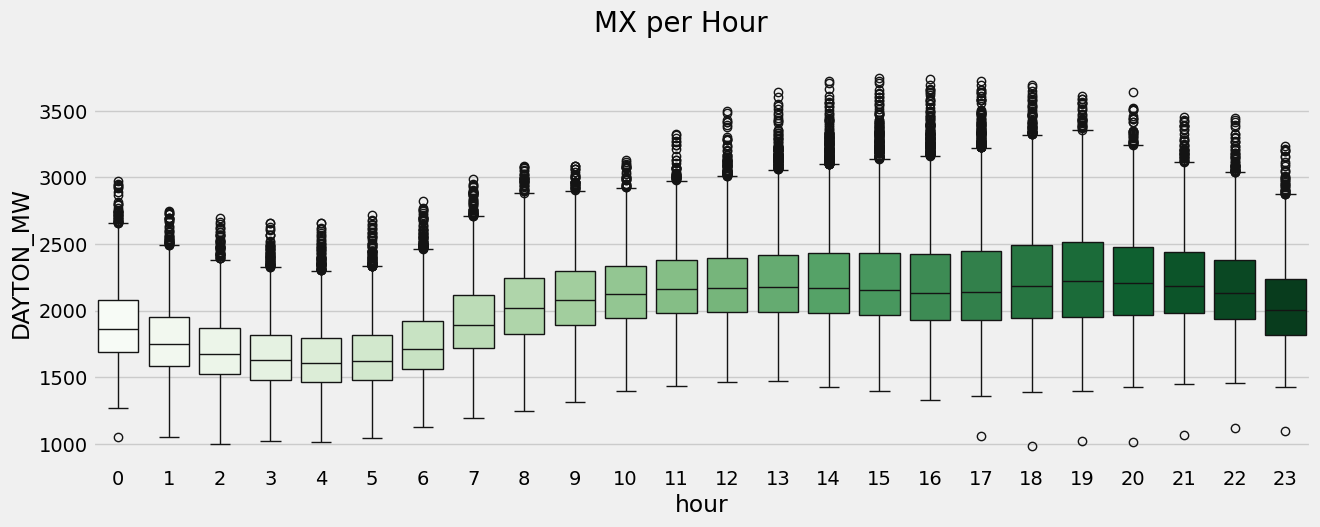

In [85]:
fig, ax = plt.subplots(figsize=(14,5))
fig.suptitle('MX per Hour', fontsize=20)
sns.boxplot(data=df, x='hour', y='DAYTON_MW',  hue='hour', palette='Greens', legend=False)
plt.show()

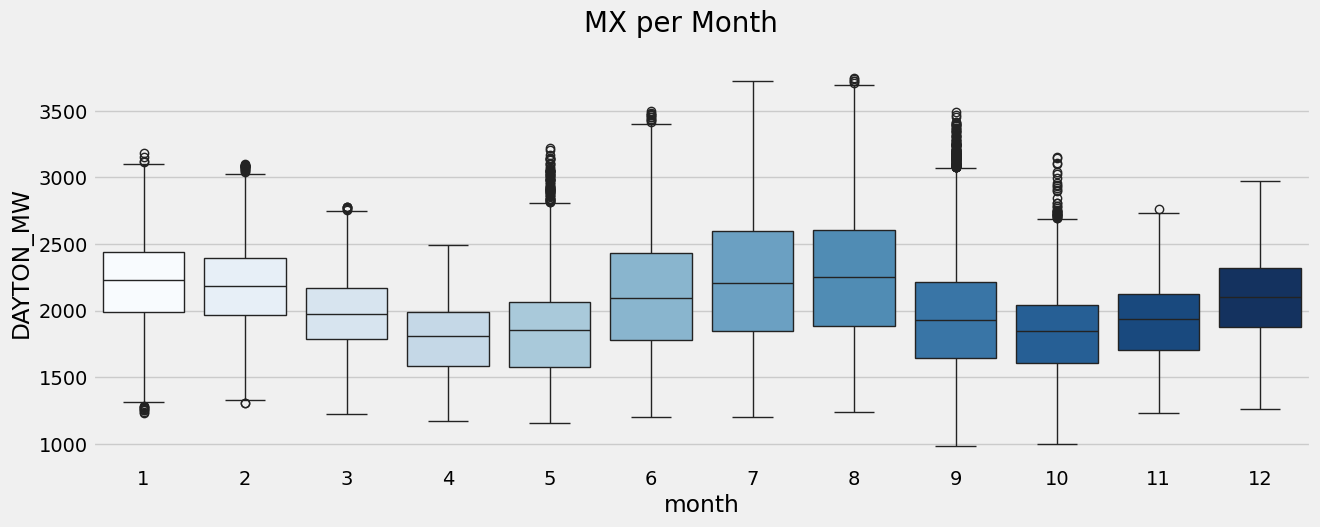

In [86]:
fig, ax = plt.subplots(figsize=(14,5))
fig.suptitle('MX per Month', fontsize=20)
sns.boxplot(data=df, x='month', y='DAYTON_MW',  hue='month', palette='Blues', legend=False)
plt.show()

## Model

In [87]:
train = create_features(train)
test = create_features(test)

In [88]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'DAYTON_MW'

In [89]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [90]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=30,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=10)

[0]	validation_0-rmse:378.93631
[10]	validation_0-rmse:356.92111
[20]	validation_0-rmse:337.07790
[30]	validation_0-rmse:320.27170
[40]	validation_0-rmse:306.45894
[50]	validation_0-rmse:294.38760
[60]	validation_0-rmse:283.94781
[70]	validation_0-rmse:274.87134
[80]	validation_0-rmse:266.50469
[90]	validation_0-rmse:259.61281
[100]	validation_0-rmse:253.56655
[110]	validation_0-rmse:248.72206
[120]	validation_0-rmse:244.59212
[130]	validation_0-rmse:241.06513
[140]	validation_0-rmse:237.92872
[150]	validation_0-rmse:235.29001
[160]	validation_0-rmse:233.19770
[170]	validation_0-rmse:231.51918
[180]	validation_0-rmse:230.05664
[190]	validation_0-rmse:228.73417
[200]	validation_0-rmse:227.70972
[210]	validation_0-rmse:226.76637
[220]	validation_0-rmse:226.03603
[230]	validation_0-rmse:225.47133
[240]	validation_0-rmse:224.95721
[250]	validation_0-rmse:224.38720
[260]	validation_0-rmse:223.99736
[270]	validation_0-rmse:223.66503
[280]	validation_0-rmse:223.59963
[290]	validation_0-rmse:2

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

### Feature Importance

In [91]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['Importance']).sort_values(by='Importance', ascending=False)
fi

,Importance
hour,0.468838
dayofweek,0.271610
dayofyear,0.114255
month,0.065223
year,0.048538
quarter,0.031535


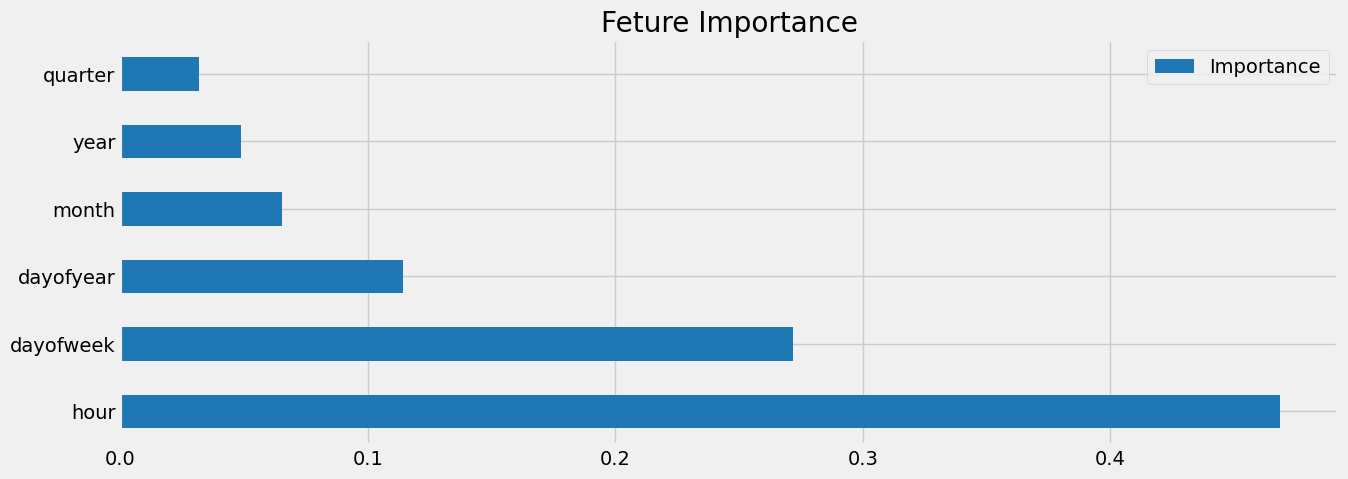

In [92]:
fi.plot(kind='barh', figsize=(14,5), title='Feture Importance')
plt.show()

### Forecasting

In [93]:
test['prediction'] = reg.predict(X_test)
test.head()

,DAYTON_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2015-01-01 00:00:00,2001.0,0,3,1,1,2015,1,2006.142700
2015-01-01 01:00:00,1950.0,1,3,1,1,2015,1,1949.270386
2015-01-01 02:00:00,1912.0,2,3,1,1,2015,1,1944.874878
2015-01-01 03:00:00,1866.0,3,3,1,1,2015,1,1927.109863
2015-01-01 04:00:00,1859.0,4,3,1,1,2015,1,1927.109863


In [94]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

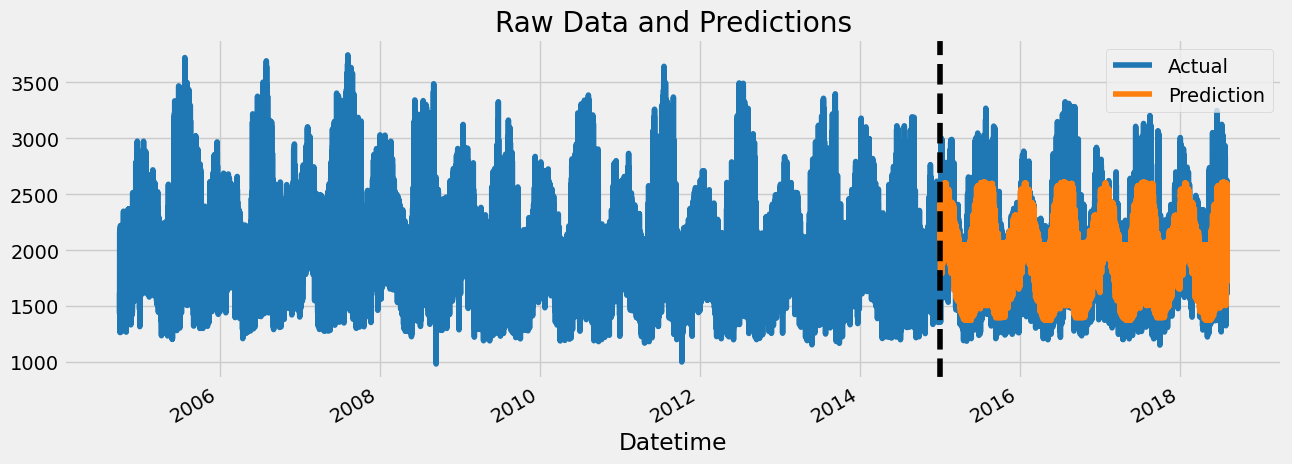

In [95]:
ax = df[['DAYTON_MW', 'prediction']].plot(figsize=(14,5))
ax.axvline('2015-01-01', color='black', ls='--')
plt.legend(['Actual', 'Prediction'])
plt.title('Raw Data and Predictions')
plt.show()

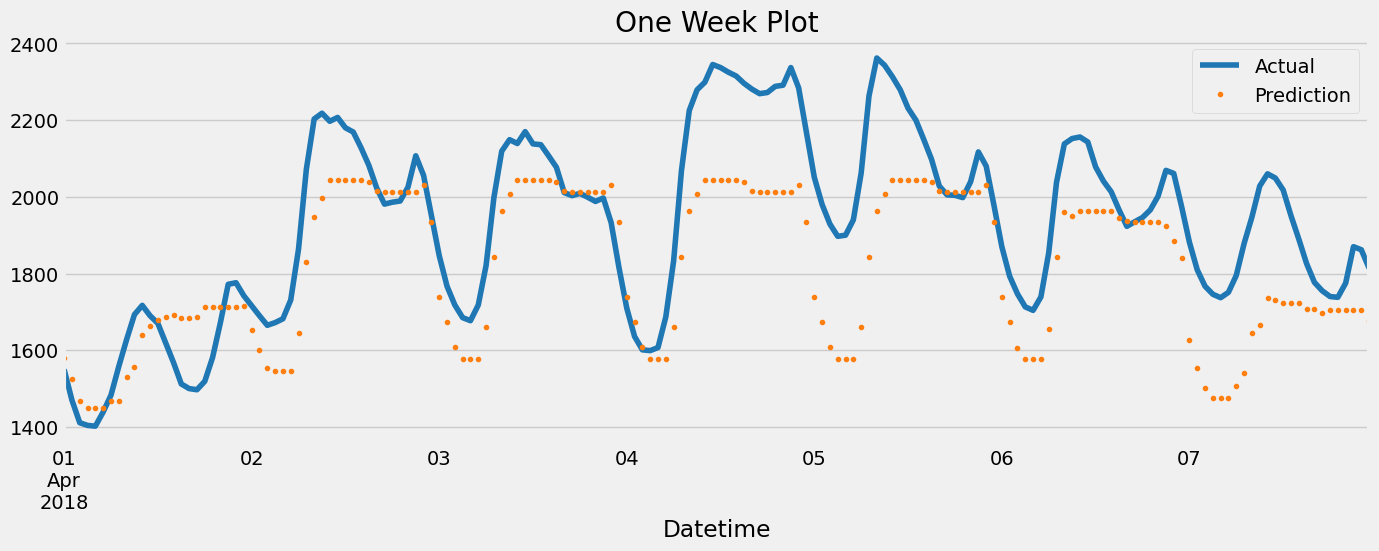

In [96]:
ax = df.loc[(df.index >= '2018-04-01') & (df.index < '2018-04-08')]['DAYTON_MW'].plot(figsize=(15,5), title='One Week Plot')
df.loc[(df.index >= '2018-04-01') & (df.index < '2018-04-08')][['prediction']].plot(ax=ax, figsize=(15,5), style='.')
plt.legend(['Actual', 'Prediction'])
plt.show()

## Evaluation

### RMSE

In [97]:
rmse = np.sqrt(mean_squared_error(y_test, test['prediction']))
print(f"RMSE: {rmse:.2f}")

RMSE: 223.51


### Error

In [98]:
test['error'] = np.abs(y_test - test.prediction)
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False)

,error
date,
2016-07-04,652.333700
2016-07-25,591.573288
2016-09-07,584.214508
2018-01-02,579.527761
2016-08-12,558.576269
...,...
2017-05-04,33.447683
2016-12-06,33.317912
2017-10-05,30.499939


# Improve times series forecasting

## Outlier analysis

<Axes: ylabel='Frequency'>

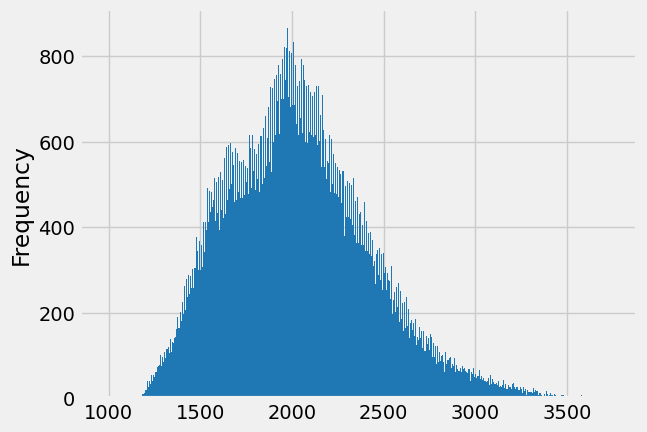

In [99]:
# histogram with 500 bins
df['DAYTON_MW'].plot(kind='hist', bins=500)

<Axes: ylabel='Frequency'>

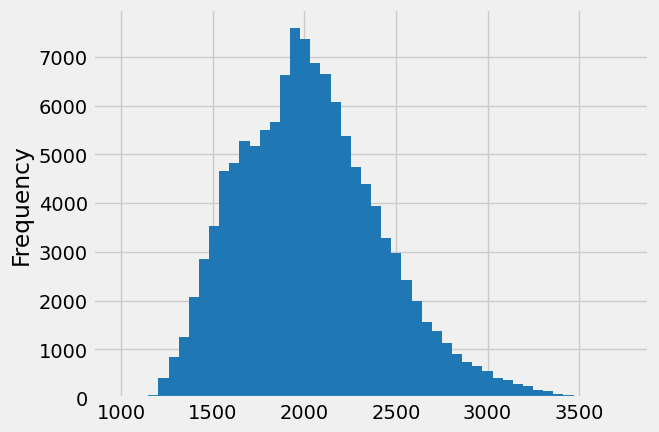

In [100]:
df['DAYTON_MW'].plot(kind='hist', bins=50)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

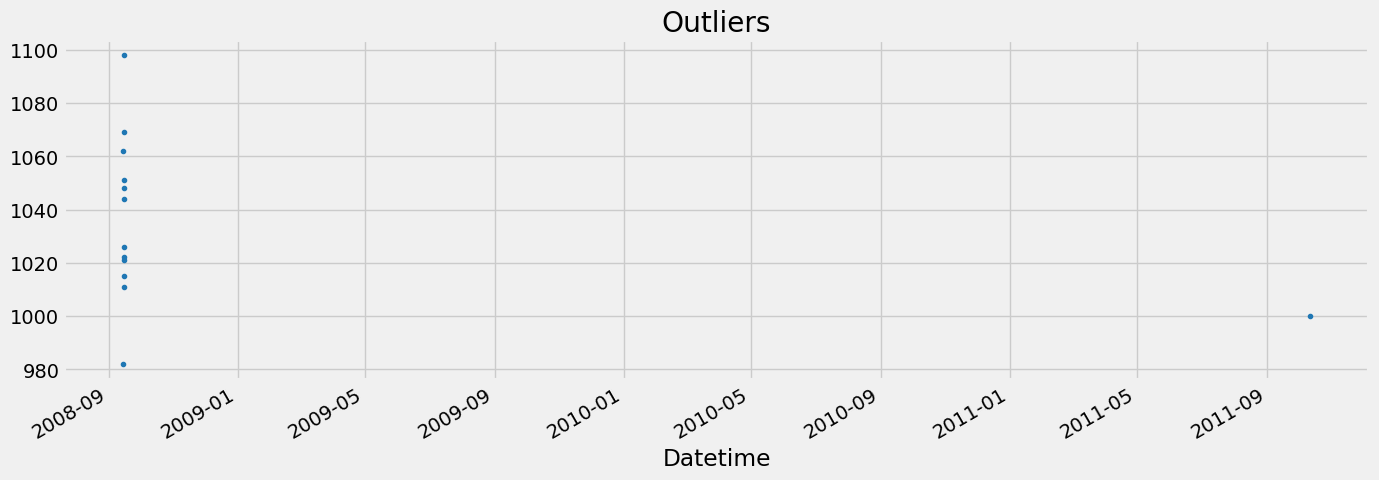

In [101]:
df.query('DAYTON_MW < 1100')['DAYTON_MW'].plot(figsize=(15,5), style='.', title='Outliers')

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

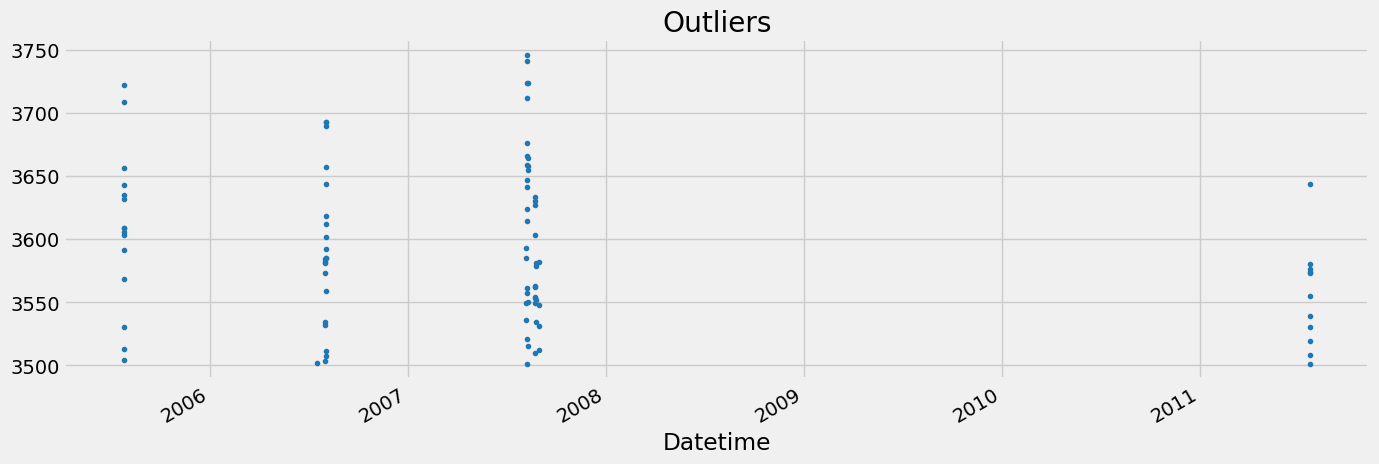

In [102]:
df.query('DAYTON_MW > 3500')['DAYTON_MW'].plot(figsize=(15,5), style='.', title='Outliers')

## Cross Validation

In [103]:
from sklearn.model_selection import TimeSeriesSplit

In [104]:
# test_size => how much in the future we want to predict, in this case one year so:
# 24 hours (date collected on hourly bases, so for each day 24 rows) * 365 days * 1 number of years
# gap => distance between dataset and prediction, in this case one day

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index() important to sort

But how does train_test_split work for time series?

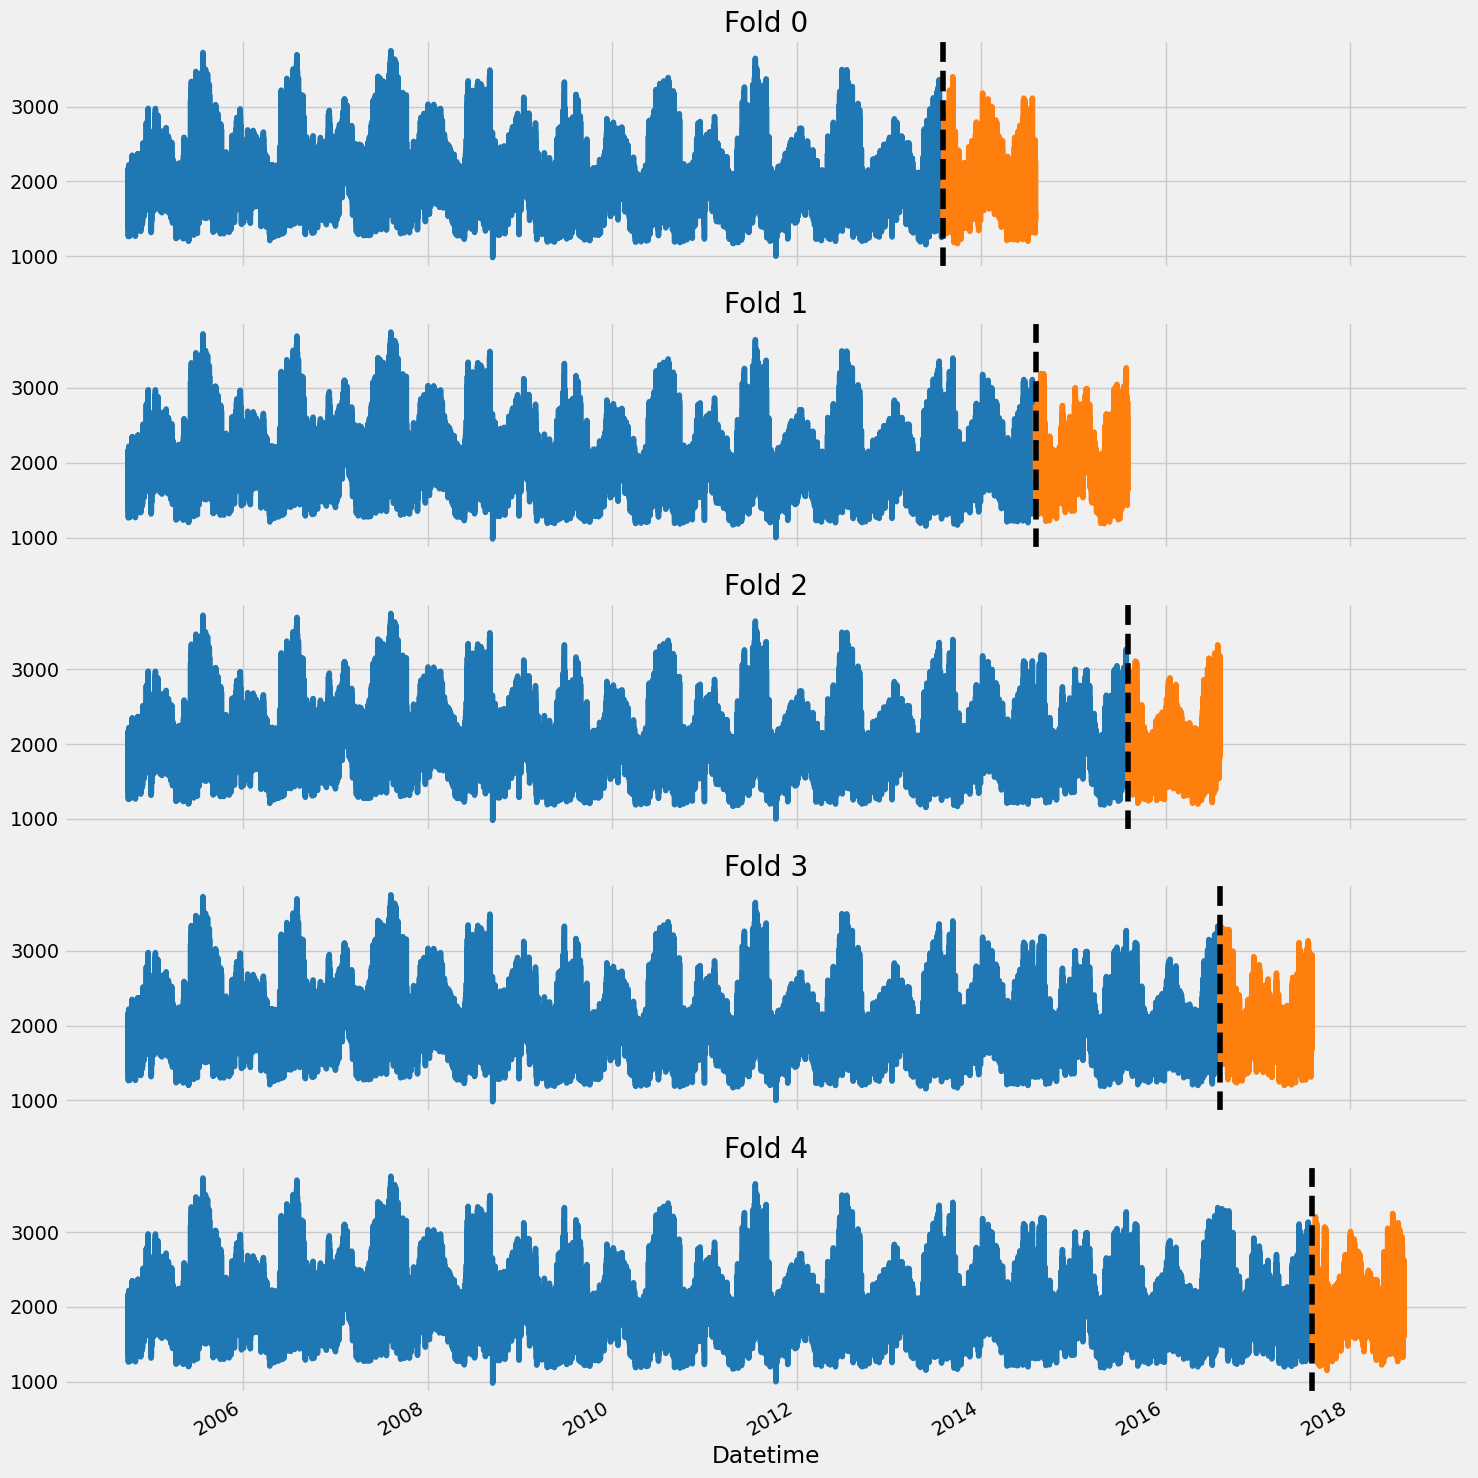

In [105]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
  train = df.iloc[train_idx]
  val = df.iloc[val_idx]
  train['DAYTON_MW'].plot(ax=axs[fold], label='Training set', title=f'Fold {fold}')
  val['DAYTON_MW'].plot(ax=axs[fold], label='Validation set')
  axs[fold].axvline(val.index.min(), color='black', ls='--')
  fold += 1

plt.tight_layout()
plt.show()

1. we start bu having n years in the testing dataset and the following year in the test/val dataset
2. the following year we add the val year to the test dataset and use the following (previousley unused year) as the new test dataset
3. repeat this for the number of folds

## Forecasting horizon

It indicates for how much into the future we want to generate forecasts (in our case 1 year)
<br>less into the future => higher accuracy
<br>more into the future => lower accuracy

## Lag Features

look back (x years/days/hours) into the past and use that value from the past as a new feature for the model: what was the value X days/hours ago?

In [106]:
def add_lags(df):
  target_dictionary = df['DAYTON_MW'].to_dict()
  df = df.copy()
  df['lag_1_year'] = (df.index - pd.Timedelta(days=364)).map(target_dictionary)
  df['lag_2_year'] = (df.index - pd.Timedelta(days=728)).map(target_dictionary)
  df['lag_3_year'] = (df.index - pd.Timedelta(days=1092)).map(target_dictionary)
  return df

In [109]:
df = add_lags(df)
# the first rows are too far back in the past, we don't have the information
# to fill in the values for 1/2/3 years in the past
df.head()

,DAYTON_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction,lag_1_year,lag_2_year,lag_3_year
Datetime,,,,,,,,,,,
2004-10-01 01:00:00,1621.0,1,4,4,10,2004,275,NaN,NaN,NaN,NaN
2004-10-01 02:00:00,1536.0,2,4,4,10,2004,275,NaN,NaN,NaN,NaN
2004-10-01 03:00:00,1500.0,3,4,4,10,2004,275,NaN,NaN,NaN,NaN
2004-10-01 04:00:00,1434.0,4,4,4,10,2004,275,NaN,NaN,NaN,NaN
2004-10-01 05:00:00,1489.0,5,4,4,10,2004,275,NaN,NaN,NaN,NaN


In [108]:
df.tail()

,DAYTON_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction,lag_1_year,lag_2_year,lag_3_year
Datetime,,,,,,,,,,,
2018-08-02 20:00:00,2554.0,20,3,3,8,2018,214,2586.391113,2845.0,3111.0,2011.0
2018-08-02 21:00:00,2481.0,21,3,3,8,2018,214,2556.937988,2734.0,3010.0,2016.0
2018-08-02 22:00:00,2405.0,22,3,3,8,2018,214,2474.781006,2649.0,2943.0,2029.0
2018-08-02 23:00:00,2250.0,23,3,3,8,2018,214,2326.773438,2435.0,2743.0,1919.0
2018-08-03 00:00:00,2042.0,0,4,3,8,2018,215,1977.093994,2205.0,2508.0,1789.0


## Train model using train-test-split and lag features

In [110]:
predictions = []
errors = []

for train_idx, val_idx in tss.split(df):
  # train and validation dataframes
  train = df.iloc[train_idx]
  val = df.iloc[val_idx]

  # generate feautures using create_features function
  train = create_features(train)
  val = create_features(val)

  # define features and targets
  FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'lag_1_year', 'lag_2_year', 'lag_3_year']
  TARGET = 'DAYTON_MW'

  # create train and validation for features and target
  X_train = train[FEATURES]
  y_train = train[TARGET]

  X_val = val[FEATURES]
  y_val = val[TARGET]

  # create model and define hyperparameters
  reg = xgb.XGBRegressor(n_estimators=1000, # number of decision trees
                         early_stopping_rounds=30,  # stops after n consecutive rounds without improving
                         learning_rate=0.01,  # how much each tree contributes to the prediction
                         base_score=y_train.mean(), # starting prediction score
                         objective='reg:squarederror', # loss functions
                         max_depth=3) # max depth of each tree

  # eval_set =>
  # if train goes down and validation goes up => overfitting
  # if both stop going down => eraly stopping stops the training
  reg.fit(X_train, y_train,
          eval_set = [(X_train, y_train), (X_val, y_val)],
          verbose=100)

  y_pred = reg.predict(X_val)
  predictions.append(y_pred)
  error = np.sqrt(mean_squared_error(y_val, y_pred))
  errors.append(error)

[0]	validation_0-rmse:398.74663	validation_1-rmse:382.19239
[100]	validation_0-rmse:279.53460	validation_1-rmse:263.08278
[200]	validation_0-rmse:244.93104	validation_1-rmse:239.23956
[300]	validation_0-rmse:228.42021	validation_1-rmse:235.73517
[322]	validation_0-rmse:225.50015	validation_1-rmse:235.95359
[0]	validation_0-rmse:397.08307	validation_1-rmse:374.20376
[100]	validation_0-rmse:278.75244	validation_1-rmse:249.46817
[200]	validation_0-rmse:245.08170	validation_1-rmse:220.72890
[300]	validation_0-rmse:230.25956	validation_1-rmse:209.62738
[400]	validation_0-rmse:221.13247	validation_1-rmse:206.02678
[500]	validation_0-rmse:215.19226	validation_1-rmse:205.36621
[556]	validation_0-rmse:212.79938	validation_1-rmse:205.34255
[0]	validation_0-rmse:395.00916	validation_1-rmse:383.74618
[100]	validation_0-rmse:276.76324	validation_1-rmse:264.24131
[200]	validation_0-rmse:243.37612	validation_1-rmse:236.94789
[300]	validation_0-rmse:229.08050	validation_1-rmse:227.02986
[400]	validati

In [115]:
print(f"Errors: {errors}")
print(f"Overall error: {np.mean(errors):0.3f}")

Errors: [np.float64(235.6358520656848), np.float64(205.28943805494347), np.float64(222.28470782690928), np.float64(241.51304040761792), np.float64(224.15045980507085)]
Overall error: 225.775


# Forecast values in the future

In [117]:
# retrain on all data
df = create_features(df)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
            'lag_1_year', 'lag_2_year', 'lag_3_year']
TARGET = 'DAYTON_MW'

# to forecast into the feature (and not simply forecast value we already had in the og ds)
# we want to leverage all the data we have
X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(n_estimators=400, # based on the results of the previous training
                       booster='gbtree', # type of tree (gbtree is default, indicates decision trees)
                       early_stopping_rounds=30,
                       learning_rate=0.01,
                       base_score=y_all.mean(),
                       objective='reg:squarederror',
                       max_depth=3)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:391.28349
[100]	validation_0-rmse:274.79312
[200]	validation_0-rmse:243.05222
[300]	validation_0-rmse:229.86715
[399]	validation_0-rmse:222.30286


XGBRegressor(base_score=np.float64(2037.8170612049703), booster='gbtree',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

## Create future dataframe

In [118]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [124]:
# added frequence because we want one pred for every hour
pd.date_range('2018-08-03', '2019-08-01', freq='1h')

DatetimeIndex(['2018-08-03 00:00:00', '2018-08-03 01:00:00',
               '2018-08-03 02:00:00', '2018-08-03 03:00:00',
               '2018-08-03 04:00:00', '2018-08-03 05:00:00',
               '2018-08-03 06:00:00', '2018-08-03 07:00:00',
               '2018-08-03 08:00:00', '2018-08-03 09:00:00',
               ...
               '2019-07-31 15:00:00', '2019-07-31 16:00:00',
               '2019-07-31 17:00:00', '2019-07-31 18:00:00',
               '2019-07-31 19:00:00', '2019-07-31 20:00:00',
               '2019-07-31 21:00:00', '2019-07-31 22:00:00',
               '2019-07-31 23:00:00', '2019-08-01 00:00:00'],
              dtype='datetime64[ns]', length=8713, freq='h')

In [129]:
future_df = pd.DataFrame(index=pd.date_range('2018-08-03', '2019-08-01', freq='1h'))
future_df['isFeature'] = True
df['isFeature'] = False
df_with_future = pd.concat([df, future_df])
df_with_future

,DAYTON_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction,lag_1_year,lag_2_year,lag_3_year,isFeature
2004-10-01 01:00:00,1621.0,1.0,4.0,4.0,10.0,2004.0,275.0,NaN,NaN,NaN,NaN,False
2004-10-01 02:00:00,1536.0,2.0,4.0,4.0,10.0,2004.0,275.0,NaN,NaN,NaN,NaN,False
2004-10-01 03:00:00,1500.0,3.0,4.0,4.0,10.0,2004.0,275.0,NaN,NaN,NaN,NaN,False
2004-10-01 04:00:00,1434.0,4.0,4.0,4.0,10.0,2004.0,275.0,NaN,NaN,NaN,NaN,False
2004-10-01 05:00:00,1489.0,5.0,4.0,4.0,10.0,2004.0,275.0,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-07-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-07-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-07-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [130]:
df_with_future = create_features(df_with_future)
df_with_future = add_lags(df_with_future)
df_with_future

,DAYTON_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction,lag_1_year,lag_2_year,lag_3_year,isFeature
2004-10-01 01:00:00,1621.0,1,4,4,10,2004,275,NaN,NaN,NaN,NaN,False
2004-10-01 02:00:00,1536.0,2,4,4,10,2004,275,NaN,NaN,NaN,NaN,False
2004-10-01 03:00:00,1500.0,3,4,4,10,2004,275,NaN,NaN,NaN,NaN,False
2004-10-01 04:00:00,1434.0,4,4,4,10,2004,275,NaN,NaN,NaN,NaN,False
2004-10-01 05:00:00,1489.0,5,4,4,10,2004,275,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,NaN,2349.0,2774.0,3082.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,NaN,2270.0,2657.0,2960.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,NaN,2257.0,2582.0,2889.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,NaN,2118.0,2403.0,2677.0,True


In [131]:
df_features_only = df_with_future[df_with_future['isFeature']].copy()
df_features_only

,DAYTON_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction,lag_1_year,lag_2_year,lag_3_year,isFeature
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,NaN,2205.0,2508.0,1789.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,NaN,2012.0,2323.0,1669.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,NaN,1880.0,2164.0,1588.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,NaN,1821.0,2058.0,1528.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,NaN,1774.0,1988.0,1488.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,NaN,2349.0,2774.0,3082.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,NaN,2270.0,2657.0,2960.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,NaN,2257.0,2582.0,2889.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,NaN,2118.0,2403.0,2677.0,True


## Predict the future

In [132]:
df_features_only['predicitons'] = reg.predict(df_features_only[FEATURES])

<Axes: title={'center': 'Future Predictions'}>

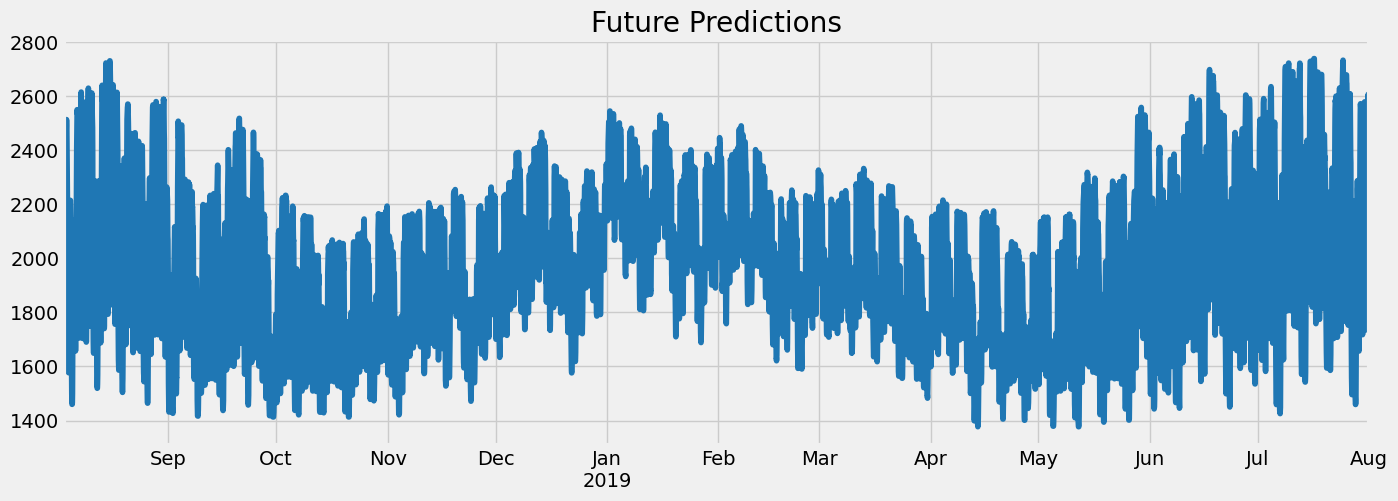

In [133]:
df_features_only['predicitons'].plot(figsize=(15,5), color=color_platte[0], title='Future Predictions')

## Save model

In [134]:
reg.save_model('energy-regressor.json')

In [135]:
loaded_reg = xgb.XGBRegressor()
loaded_reg.load_model('energy-regressor.json')

<Axes: title={'center': 'Future Predictions'}>

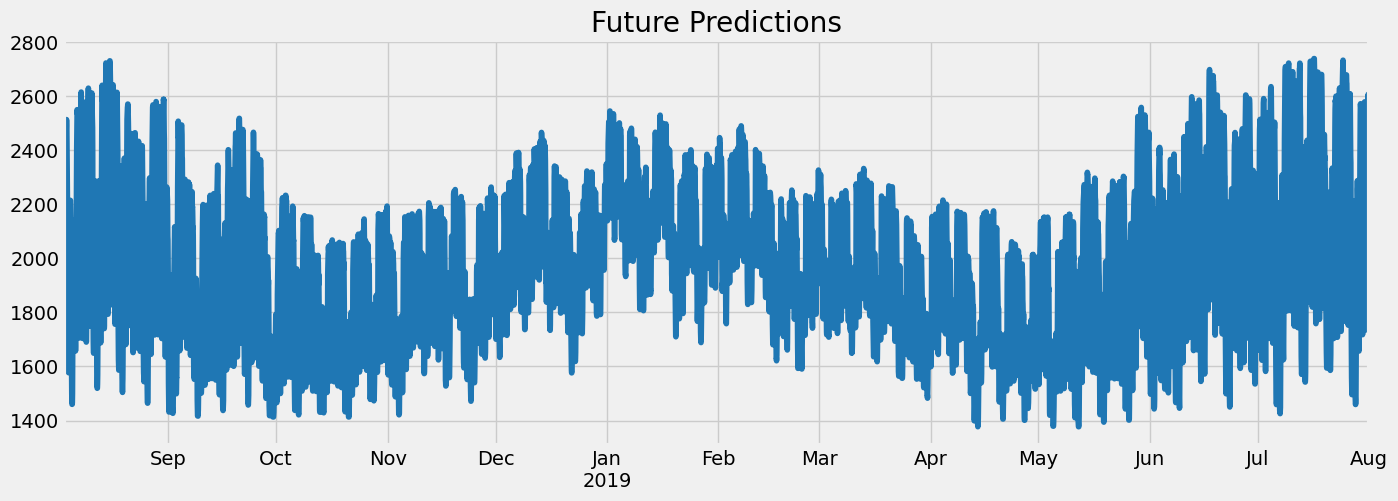

In [136]:
df_features_only['predicitons'] = loaded_reg.predict(df_features_only[FEATURES])
df_features_only['predicitons'].plot(figsize=(15,5), color=color_platte[0], title='Future Predictions')